Import libraries, import data, prepare train/test split. Standard stuff.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, \
                                    Activation, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from tensorflow.image import pad_to_bounding_box
from tensorflow.keras.layers import LayerNormalization

In [20]:
# Load the NPZ file
data = np.load('/flatland_train.npz')

# Access the arrays in the NPZ file
X = data['X']  # The input data (images)
y = data['y']  # The corresponding labels

y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X / 255.      # Scale down to range [0, 1]

# Optionally, if you want to close the file after loading
data.close()

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Make copies of images from our train set by shifting them by a fixed amount of pixels in either direction: up, down, right or left. This is to account for shapes that are not fully contained in the image, and hopefully help the model learn shapes based on angle sizes

In [36]:
shift_amount = 10  # Adjust as needed

# Create an empty array to store the shifted images
X_train_shifted_right = np.zeros(X_train.shape)

# Iterate through each image in X_train and apply the shift
for i, image in enumerate(X_train):
    # Shift the image to the right (positive direction)
    shifted_image = np.roll(image, shift_amount, axis=1)

    # Fill the empty spaces with black pixels (0)
    if shift_amount > 0:
        shifted_image[:, :shift_amount] = 0
    elif shift_amount < 0:
        shifted_image[:, shift_amount:] = 0

    X_train_shifted_right[i] = shifted_image

shift_amount = -10

X_train_shifted_left = np.zeros(X_train.shape)

# Iterate through each image in X_train and apply the shift
for i, image in enumerate(X_train):
    # Shift the image to the right (positive direction)
    shifted_image = np.roll(image, shift_amount, axis=1)

    # Fill the empty spaces with black pixels (0)
    if shift_amount > 0:
        shifted_image[:, :shift_amount] = 0
    elif shift_amount < 0:
        shifted_image[:, shift_amount:] = 0

    X_train_shifted_left[i] = shifted_image

shift_amount = 10

X_train_shifted_up = np.zeros(X_train.shape)

# Iterate through each image in X_train and apply the shift
for i, image in enumerate(X_train):
    # Shift the image upwards (positive direction)
    shifted_image = np.roll(image, shift_amount, axis=0)

    # Fill the empty spaces with black pixels (0)
    if shift_amount > 0:
        shifted_image[:shift_amount, :] = 0
    elif shift_amount < 0:
        shifted_image[shift_amount:, :] = 0

    X_train_shifted_up[i] = shifted_image

shift_amount = -10

X_train_shifted_down = np.zeros(X_train.shape)

# Iterate through each image in X_train and apply the shift
for i, image in enumerate(X_train):
    # Shift the image upwards (positive direction)
    shifted_image = np.roll(image, shift_amount, axis=0)

    # Fill the empty spaces with black pixels (0)
    if shift_amount > 0:
        shifted_image[:shift_amount, :] = 0
    elif shift_amount < 0:
        shifted_image[shift_amount:, :] = 0

    X_train_shifted_down[i] = shifted_image

Do the same but shift towards the corners: upleft, upright, downleft, downright

In [37]:
shift_amount = 10  # Adjust as needed

# Create an empty array to store the shifted images
X_train_shifted_upright = np.zeros(X_train.shape)

# Iterate through each image in X_train and apply the shift
for i, image in enumerate(X_train_shifted_up):
    # Shift the image to the right (positive direction)
    shifted_image = np.roll(image, shift_amount, axis=1)

    # Fill the empty spaces with black pixels (0)
    if shift_amount > 0:
        shifted_image[:, :shift_amount] = 0
    elif shift_amount < 0:
        shifted_image[:, shift_amount:] = 0

    X_train_shifted_upright[i] = shifted_image

shift_amount = -10

X_train_shifted_upleft = np.zeros(X_train.shape)

# Iterate through each image in X_train and apply the shift
for i, image in enumerate(X_train_shifted_up):
    # Shift the image to the right (positive direction)
    shifted_image = np.roll(image, shift_amount, axis=1)

    # Fill the empty spaces with black pixels (0)
    if shift_amount > 0:
        shifted_image[:, :shift_amount] = 0
    elif shift_amount < 0:
        shifted_image[:, shift_amount:] = 0

    X_train_shifted_upleft[i] = shifted_image

shift_amount = 10  # Adjust as needed

# Create an empty array to store the shifted images
X_train_shifted_downright = np.zeros(X_train.shape)

# Iterate through each image in X_train and apply the shift
for i, image in enumerate(X_train_shifted_down):
    # Shift the image to the right (positive direction)
    shifted_image = np.roll(image, shift_amount, axis=1)

    # Fill the empty spaces with black pixels (0)
    if shift_amount > 0:
        shifted_image[:, :shift_amount] = 0
    elif shift_amount < 0:
        shifted_image[:, shift_amount:] = 0

    X_train_shifted_downright[i] = shifted_image

shift_amount = -10

X_train_shifted_downleft = np.zeros(X_train.shape)

# Iterate through each image in X_train and apply the shift
for i, image in enumerate(X_train_shifted_down):
    # Shift the image to the right (positive direction)
    shifted_image = np.roll(image, shift_amount, axis=1)

    # Fill the empty spaces with black pixels (0)
    if shift_amount > 0:
        shifted_image[:, :shift_amount] = 0
    elif shift_amount < 0:
        shifted_image[:, shift_amount:] = 0

    X_train_shifted_downleft[i] = shifted_image

In [11]:
X_train_negative = 1 - X_train

Expand our train sets by combining all the 9 versions of each image

In [45]:
X_train = np.concatenate((X_train, X_train_shifted_up, X_train_shifted_down, X_train_shifted_right, X_train_shifted_left), axis=0)
X_train = np.concatenate((X_train, X_train_shifted_upleft, X_train_shifted_downleft, X_train_shifted_upright, X_train_shifted_downright), axis=0)
y_train = np.concatenate((y_train, y_train, y_train, y_train, y_train, y_train, y_train, y_train, y_train,), axis=0)

In [ ]:
X_train = np.concatenate((X_train, X_train_negative), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

Some vizualization:

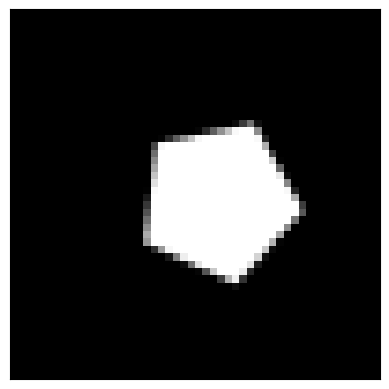

In [15]:
image = X_train[7002]

# Create a figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(image, cmap='gray')

# Remove axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])

# Show the image
plt.show()

A simple CNN model is sufficient for this task. No fancy architecture

In [16]:
# geriausias modelis so far
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(LayerNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(LayerNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(LayerNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(LayerNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(LayerNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(learning_rate=3e-4),  # Adjust the learning rate as needed
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 layer_normalization (Layer  (None, 48, 48, 32)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 layer_normalization_1 (Lay  (None, 22, 22, 64)        128       
 erNormalization)                                                
                                                        

In [ ]:
# tiny model bandymas

model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(LayerNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(LayerNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(LayerNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(LayerNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(LayerNormalization())
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(LayerNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(learning_rate=3e-4),  # Adjust the learning rate as needed
              metrics=["accuracy"])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 48, 48, 4)         40        
                                                                 
 layer_normalization_57 (La  (None, 48, 48, 4)         8         
 yerNormalization)                                               
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 24, 24, 4)         0         
 ng2D)                                                           
                                                                 
 dropout_57 (Dropout)        (None, 24, 24, 4)         0         
                                                                 
 conv2d_38 (Conv2D)          (None, 24, 24, 8)         296       
                                                                 
 layer_normalization_58 (La  (None, 24, 24, 8)       

Train our model until we reach satisfactory validation set accuracy

In [26]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',     # The metric to monitor for improvement (e.g., validation loss)
    patience=10,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights to the best observed during training
)

In [46]:
loss = model.fit(X_train, y_train, epochs=100, validation_data=[X_test, y_test], callbacks=[early_stopping])


Epoch 1/100
2250/2250 [==============================] - 43s 13ms/step - loss: 0.8617 - accuracy: 0.6668 - val_loss: 0.1550 - val_accuracy: 0.9685
Epoch 2/100
2250/2250 [==============================] - 29s 13ms/step - loss: 0.1886 - accuracy: 0.9600 - val_loss: 0.1204 - val_accuracy: 0.9805
Epoch 3/100
2250/2250 [==============================] - 29s 13ms/step - loss: 0.1432 - accuracy: 0.9743 - val_loss: 0.1130 - val_accuracy: 0.9835
Epoch 4/100
2250/2250 [==============================] - 28s 13ms/step - loss: 0.1319 - accuracy: 0.9767 - val_loss: 0.1064 - val_accuracy: 0.9850
Epoch 5/100
2250/2250 [==============================] - 29s 13ms/step - loss: 0.1233 - accuracy: 0.9794 - val_loss: 0.1067 - val_accuracy: 0.9840
Epoch 6/100
2250/2250 [==============================] - 29s 13ms/step - loss: 0.1186 - accuracy: 0.9805 - val_loss: 0.1050 - val_accuracy: 0.9850
Epoch 7/100
2250/2250 [==============================] - 29s 13ms/step - loss: 0.1157 - accuracy: 0.9813 - val_loss: 0

In [48]:
results = model.evaluate(X_test, y_test)

63/63 [==============================] - 1s 11ms/step - loss: 0.1064 - accuracy: 0.9850


In [49]:
model.save('my_model.h5')
from google.colab import files

# Download the saved model file to your local machine
files.download('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>